# **Proyecto Final | Análisis de grandes volúmenes de datos**

**Equipo 24**

| Integrantes  | Matricula |
|---------|------|
| Marilyn Sofia Mori Castillo  | A01796415   |
| Iván Alejandro Pedraza Macias  | A01795371 |
| Luis Alejandro Juárez Rodríguez | A01795463   |
| Luis Carlos Alberto Espinosa Alvarado | A00816016  |


Índice
1. Caracterización de la población
2. Recolección de datos
3. Limpieza y Preprocesamiento de Datos
4. Construccion de muestra M representativa de la población P
5. Estrategia del muestreo
6. Preparación de conjuntos de entrenamiento y prueba
7. Selección de métricas para medir calidad de resultados
8. Selección del algoritmo de aprendizaje
9. Técnicas para el ajuste de hiper–parámetros
10. Evaluación del Modelo en el Conjunto de Pruebas
11. Visualizacion de las metricas y hallazgos en los resultados
12. Discusión de resultados resultados obtenidos y y conclusiones


In [ ]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
#from pyspark.sql.functions import col, hour, dayofweek, month, count, when, struct, concat_ws
from pyspark.sql.types import IntegerType, StringType, DoubleType, TimestampType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import builtins
import math # Para manejar posibles valores NaN
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

25/06/22 10:37:11 WARN Utils: Your hostname, debian-ml resolves to a loopback address: 127.0.1.1; using 192.168.1.123 instead (on interface enp4s0)
25/06/22 10:37:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/22 10:37:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## **1. Caracterización de la Población**

- Antecedentes del Problema de Investigación:

Contexto del dataset yellow_tripdata_2015-01.csv: Datos de viajes de taxi en Nueva York. Los datos de viajes de taxi son una fuente rica para descubrir patrones de movilidad, optimizar servicios, predecir demanda o incluso identificar anomalías.

El dataset yellow_tripdata_2015-01.csv contiene las siguientes columnas principales, que representan las características de nuestra población de viajes de taxi:

    vendor_id: Identificador del proveedor de Taxis.
    tpep_pickup_datetime: Fecha y hora de inicio del viaje.
    tpep_dropoff_datetime: Fecha y hora de finalización del viaje.passenger_count: Número de pasajeros.
    trip_distance: Distancia del viaje en millas.
    pickup_longitude, pickup_latitude: Coordenadas geográficas de la recogida.
    dropoff_longitude, dropoff_latitude: Coordenadas geográficas de la bajada.
    ratecodeid: Tarifa de código final del viaje.
    store_and_fwd_flag: Bandera indicando si el viaje fue almacenado y enviado (conexión a internet).
    payment_type: Tipo de pago (ej., efectivo, tarjeta de crédito).
    fare_amount: Monto de la tarifa básica. (Nuestra variable objetivo)
    extra: Extras de la tarifa.
    mta_tax: Impuesto MTA.
    tip_amount: Monto de la propina.
    tolls_amount: Monto de los peajes.
    improvement_surcharge: Recargo de mejora.
    total_amount: Monto total cobrado al pasajero.

Nuestra variable objetivo para la predicción será el **total_amount**, ya que es un indicador clave de los ingresos y un valor continuo, lo que lo convierte en un problema de regresión que abordaremos usando modelos de aprendizaje automático con PySpark.

## **2. Recolección de Datos | Lectura de información**

In [ ]:
# Lectura de informacion
df = spark.read.option("header", True).option("inferSchema", True).csv("../data/yellow_tripdata/yellow_tripdata_2015-01.csv")
print(f"Número de filas: {df.count()}")
print(f"Número de columnas: {df.columns}")
df.show(5)

Número de filas: 12748986
Número de columnas: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+-----------

In [3]:
p_df = df.drop("VendorID", "pickup_longitude", "pickup_latitude", "RateCodeID", "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag", "extra", "tolls_amount", "mta_tax")
print("Número de registros: " + str(p_df.count()))
print("Número de columnas: " + str(len(p_df.columns)))
# Mostrar las primeras 5 filas
print("Primeras 5 filas del DataFrame:")
p_df.show(5)

Número de registros: 12748986
Número de columnas: 9
Primeras 5 filas del DataFrame:
+--------------------+---------------------+---------------+-------------+------------+-----------+----------+---------------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|payment_type|fare_amount|tip_amount|improvement_surcharge|total_amount|
+--------------------+---------------------+---------------+-------------+------------+-----------+----------+---------------------+------------+
| 2015-01-15 19:05:39|  2015-01-15 19:23:42|              1|         1.59|           1|       12.0|      3.25|                  0.3|       17.05|
| 2015-01-10 20:33:38|  2015-01-10 20:53:28|              1|          3.3|           1|       14.5|       2.0|                  0.3|        17.8|
| 2015-01-10 20:33:38|  2015-01-10 20:43:41|              1|          1.8|           2|        9.5|       0.0|                  0.3|        10.8|
| 2015-01-10 20:33:39|  2015-01-10 20:35

* Exploración básica de los datos iniciales

In [4]:
# Estadísticas descriptivas de las columnas numéricas
print("\nEstadísticas descriptivas:")
p_df.describe([
    "passenger_count", "trip_distance", "fare_amount",
    "payment_type", "tip_amount",
    "improvement_surcharge", "total_amount"
]).show()


Estadísticas descriptivas:


25/06/22 10:37:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+------------------+---------------------+------------------+
|summary|   passenger_count|     trip_distance|       fare_amount|      payment_type|        tip_amount|improvement_surcharge|      total_amount|
+-------+------------------+------------------+------------------+------------------+------------------+---------------------+------------------+
|  count|          12748986|          12748986|          12748986|          12748986|          12748986|             12748983|          12748986|
|   mean|1.6814908260154964|13.459129611562537|11.905659425777182|1.3867115392549652| 1.853813646041934|   0.2831430789385838|15.108294537379894|
| stddev| 1.337923517287465| 9844.094218468368|10.302537135952251|  0.49886106350539|1106.4323141838956|   0.0690863293583079|1106.5032467104797|
|    min|                 0|               0.0|            -450.0|                 1|            -92.42|                  0.

In [5]:
# fare_amount: Monto de la tarifa básica. (Nuestra variable objetivo)

# ----- Distribución del monto de la tarifa
# Recolectar una muestra para visualización (cuidado con datasets grandes)
sample_fare = df.select("total_amount").sample(False, 0.1, 42).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(sample_fare["total_amount"], bins=50, kde=True)
plt.title('Distribución del Monto de la Tarifa (total_amount)')
plt.xlabel('Monto total de la Tarifa del viaje')
plt.ylabel('Frecuencia')
plt.xlim(0, 100) # Limitar para mejor visualización, ya que puede haber outliers
plt.grid(True)
plt.show()

# ----- Conteo de pasajeros
passenger_counts = df.groupBy("passenger_count").count().orderBy("passenger_count").toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x='passenger_count', y='count', data=passenger_counts)
plt.title('Número de Viajes por Conteo de Pasajeros')
plt.xlabel('Conteo de Pasajeros')
plt.ylabel('Número de Viajes')
plt.grid(axis='y')
plt.show()

# ----- Tipo de pago
payment_types = df.groupBy("payment_type").count().orderBy(col("count").desc()).toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x='payment_type', y='count', data=payment_types)
plt.title('Número de Viajes por Tipo de Pago')
plt.xlabel('Tipo de Pago')
plt.ylabel('Número de Viajes')
plt.grid(axis='y')
plt.show()

NameError: name 'plt' is not defined

##    **3. Limpieza y Preprocesamiento de Datos**

In [ ]:
# Eliminar filas con valores nulos en columnas críticas para el análisis o modelado
initial_rows = p_df.count()
p_df = p_df.dropna(subset=["tpep_pickup_datetime", "tpep_dropoff_datetime", "fare_amount", "trip_distance", "passenger_count"])
print(f"Filas eliminadas debido a nulos: {initial_rows - p_df.count()}")

# Convertir columnas de fecha/hora a tipo Timestamp si inferSchema no lo hizo correctamente
p_df = p_df.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime")))
p_df = p_df.withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

# Asegurarse de que las columnas numéricas clave sean de tipo Double
numeric_cols = ["passenger_count", "trip_distance", "fare_amount",
                "payment_type", "tip_amount",
                "improvement_surcharge", "total_amount"]
for col_name in numeric_cols:
    p_df = p_df.withColumn(col_name, col(col_name).cast(DoubleType()))

p_df.printSchema()

Filas eliminadas debido a nulos: 0
root
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [ ]:
# 2.1.Creación de Nuevas Características (Feature Engineering)
# -------------------------------------------------------------------------
# Duración del viaje en segundos y luego en minutos
p_df = p_df.withColumn("trip_duration_seconds", unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime")))
p_df = p_df.withColumn("trip_duration_minutes", col("trip_duration_seconds") / 60)

# Extraer características de tiempo
p_df = p_df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
p_df = p_df.withColumn("pickup_dayofweek", dayofweek(col("tpep_pickup_datetime"))) # 1=Domingo, 7=Sábado

# Tarifa por milla (fare_amount / trip_distance)
p_df = p_df.withColumn("fare_per_mile", col("fare_amount") / col("trip_distance"))
p_df = p_df.na.fill(0, subset=["fare_per_mile"]) # Rellenar NaN (división por cero)
p_df = p_df.withColumn("fare_per_mile",
                   when(col("fare_per_mile").isin(float('inf'), float('-inf')), 0)
                   .otherwise(col("fare_per_mile")))

# trip_distance_bind
p_df = p_df.withColumn("trip_distance_bind",
                       when(col("trip_distance") <= 1.0, 1) # Ej: <= 1 milla
                       .when((col("trip_distance") > 1.0) & (col("trip_distance") <= 5.0), 2) # Ej: 1-5 millas
                       .otherwise(3) # Ej: > 5 millas
)


# Para 'duration_bind': podemos categorizar en duraciones cortas, medianas y largas
p_df = p_df.withColumn("duration_bind",
                       when(col("trip_duration_minutes") <= 10.0, 1) # Ej: <= 10 minutos
                       .when((col("trip_duration_minutes") > 10.0) & (col("trip_duration_minutes") <= 30.0), 2) # Ej: 10-30 minutos
                       .otherwise(3)      #Ej: > 30 minutos
)

# total_amount
p_df = p_df.withColumn("total_amount_bind",
                       when((col("total_amount") > 0) & (col("total_amount") <= 10.0), 1)
                       .when((col("total_amount") > 10.0) & (col("total_amount") <= 20.0), 2)
                       .when((col("total_amount") > 20.0) & (col("total_amount") <= 100.0), 3)
)

# passenger_count
p_df = p_df.withColumn("passenger_count_bind",
                       when((col("passenger_count") > 0) & (col("passenger_count") <= 1.0), 1)
                       .when((col("passenger_count") > 1.0) & (col("passenger_count") <= 10.0), 2)
)

# payment_type
p_df = p_df.withColumn("payment_type_bind",
                       when((col("payment_type") == 1.0), 1)
                       .when((col("payment_type") > 1.0) & (col("payment_type") <= 6.0), 2)
)

p_df.show(5)
p_df.printSchema()

+--------------------+---------------------+---------------+-------------+------------+-----------+----------+---------------------+------------+---------------------+---------------------+-----------+----------------+------------------+------------------+-------------+-----------------+--------------------+-----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|payment_type|fare_amount|tip_amount|improvement_surcharge|total_amount|trip_duration_seconds|trip_duration_minutes|pickup_hour|pickup_dayofweek|     fare_per_mile|trip_distance_bind|duration_bind|total_amount_bind|passenger_count_bind|payment_type_bind|
+--------------------+---------------------+---------------+-------------+------------+-----------+----------+---------------------+------------+---------------------+---------------------+-----------+----------------+------------------+------------------+-------------+-----------------+--------------------+-----------------+
| 2015-01-15 19:

In [ ]:
# --- Filtrado de Outliers y Datos Inválidos/Inconsistentes ---
#print("\n--- 2.2. Modelamiento con RandomForestClassifier + Hiperparámetros ---")
print(f"Filas antes de filtrar outliers: {df.count()}")

df_filtered = p_df.filter(
    (col("passenger_count") > 0) & (col("passenger_count") <= 6) &
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) & (col("fare_amount") < 500) &
    (col("trip_duration_minutes") > 0) & (col("trip_duration_minutes") < 240)
)

df_filtered = df_filtered.drop("tpep_pickup_datetime", "tpep_dropoff_datetime")
print(f"Filas después de filtrar outliers: {df_filtered.count()}")

# Almacenar en caché el DataFrame filtrado para un acceso más rápido
df_filtered.cache()

Filas antes de filtrar outliers: 12748986
Filas después de filtrar outliers: 12647534


passenger_count,trip_distance,payment_type,fare_amount,tip_amount,improvement_surcharge,total_amount,trip_duration_seconds,trip_duration_minutes,pickup_hour,pickup_dayofweek,fare_per_mile,trip_distance_bind,duration_bind,total_amount_bind,passenger_count_bind,payment_type_bind
1.0,1.59,1.0,12.0,3.25,0.3,17.05,1083,18.05,19,5,7.547169811320754,2,2,2,1,1
1.0,3.3,1.0,14.5,2.0,0.3,17.8,1190,19.833333333333332,20,7,4.3939393939393945,2,2,2,1,1
1.0,1.8,2.0,9.5,0.0,0.3,10.8,603,10.05,20,7,5.277777777777778,2,2,2,1,2
1.0,0.5,2.0,3.5,0.0,0.3,4.8,112,1.8666666666666667,20,7,7.0,1,1,1,1,2
1.0,3.0,2.0,15.0,0.0,0.3,16.3,1159,19.316666666666666,20,7,5.0,2,2,2,1,2
1.0,9.0,1.0,27.0,6.7,0.3,40.33,1213,20.216666666666665,20,7,3.0,3,2,3,1,1
1.0,2.2,2.0,14.0,0.0,0.3,15.3,1492,24.866666666666667,20,7,6.363636363636363,2,2,2,1,2
3.0,0.8,1.0,7.0,1.66,0.3,9.96,521,8.683333333333334,20,7,8.75,1,1,1,2,1
3.0,18.2,2.0,52.0,0.0,0.3,58.13,2276,37.93333333333333,20,7,2.857142857142857,3,3,3,2,2
2.0,0.9,1.0,6.5,1.55,0.3,9.35,424,7.066666666666666,20,7,7.222222222222222,1,1,1,2,1


##    **4. Construccion de muestra M representativa de la población P (considerando el volumen)**

In [ ]:
# 1.3. Definir Variables de Caracterización y Estrategia de Muestreo
# -------------------------------------------------------------------------------
print("\nPaso 4.1: Definiendo variables de caracterización y estrategia de muestreo para M...")
# Identificar las variables clave para la estratificación por las cuales queremos asegurar la representatividad.
stratification_cols = ["passenger_count",
                       "trip_distance_bind",
                       "duration_bind",
                       "payment_type_bind"]

# Paso 1: Crear una columna compuesta de estratos combinados en una sola columna de tipo String.
# Esto es necesario porque sampleBy espera una única columna para estratificar.
combined_strata_col_name = "stratification_key"
df_processed_with_composite_key = df_filtered.withColumn(
    combined_strata_col_name,
    # Concatenar los valores de las columnas en un string, usando '_' como separador.
    # Es vital castear a String todos los componentes para evitar errores de tipo.
    concat_ws("_", *[col(c).cast("string") for c in stratification_cols])
)

# Cachea el nuevo DataFrame con la columna de estrato combinada
df_processed_with_composite_key.cache()
print(f"Columna '{combined_strata_col_name}' creada para estratificación combinada.")
print("Esquema del DataFrame con la nueva columna de estrato (primeras columnas relevantes):")
df_processed_with_composite_key.select(stratification_cols + [combined_strata_col_name]).limit(5).show(truncate=False)

# Calcular las proporciones de cada estrato en la población P
print("Calculando distribuciones de estratos en la población P...")
strata_distribution = df_processed_with_composite_key.groupBy(combined_strata_col_name).agg(count("*").alias("count"))
total_population_count = df_processed_with_composite_key.count()
strata_distribution = strata_distribution.withColumn("proportion", col("count") / total_population_count)
strata_distribution.cache()
print("Distribución de estratos calculada. Ejemplo de los 5 estratos más grandes:")
strata_distribution.orderBy(col("count").desc()).limit(5).show(truncate=False)

# Paso 2: Calcular las fracciones por estrato para el sampleBy
# Definir el tamaño deseado de la muestra M
sample_fraction = 0.05 # Ej: 5% de cada estrato para la muestra M
target_sample_size_M = int(total_population_count * sample_fraction)
print(f"Tamaño deseado de la muestra M: {target_sample_size_M} registros (aproximadamente {sample_fraction*100}% de la población).")

# Obtenemos las claves de estratificación únicas por estratos
print("Recolectando estratos para construir el diccionario de fracciones...")
distinct_strata_keys = df_processed_with_composite_key.select("stratification_key").distinct().collect()

# Crear un diccionario de fracciones donde la clave es el valor de la columna compuesta
# y el valor es la fracción a muestrear.
fractions_dict = {row.stratification_key: sample_fraction for row in distinct_strata_keys}
print(f"Diccionario de fracciones de muestreo creado para {len(fractions_dict)} estratos.")


Paso 3.1: Definiendo variables de caracterización y estrategia de muestreo para M...
Columna 'stratification_key' creada para estratificación combinada.
Esquema del DataFrame con la nueva columna de estrato (primeras columnas relevantes):
+---------------+------------------+-------------+-----------------+------------------+
|passenger_count|trip_distance_bind|duration_bind|payment_type_bind|stratification_key|
+---------------+------------------+-------------+-----------------+------------------+
|1.0            |2                 |2            |1                |1.0_2_2_1         |
|1.0            |2                 |2            |1                |1.0_2_2_1         |
|1.0            |2                 |2            |2                |1.0_2_2_2         |
|1.0            |1                 |1            |2                |1.0_1_1_2         |
|1.0            |2                 |2            |2                |1.0_2_2_2         |
+---------------+------------------+-------------+------

##    **5. Estrategia de Muestreo usado: Estratificado**

In [ ]:
# 5.1: Generar la muestra M usando muestreo estratificado con la nueva columna compuesta
# -------------------------------------------------------------------------------
print("\nPaso: 5.1. Construyendo la muestra M representativa de la población P (muestreo estratificado)...")
m_df = df_processed_with_composite_key.sampleBy("stratification_key", fractions_dict, seed=42)
actual_m_size = m_df.count()
print(f"\nNúmero de registros en la muestra M (estratificada): {actual_m_size}")
m_df.cache()
#m_df.printSchema()
print(f"Proporción real de M respecto a P: {actual_m_size / total_population_count:.4f}")

# 5.2: Verificar la representatividad de M comparando distribuciones
# -------------------------------------------------------------------
print("\nVerificando representatividad de M (comparando distribuciones de estratos):")
m_strata_distribution = m_df.groupBy(combined_strata_col_name).agg(count("*").alias("count_m"))
m_strata_distribution = m_strata_distribution.withColumn("proportion_m", col("count_m") / actual_m_size)
m_strata_distribution.cache() # Cachear si se va a usar más de una vez

# Unir y comparar las proporciones
comparison_df = strata_distribution.join(m_strata_distribution, on=combined_strata_col_name, how="left_outer") \
                                    .withColumn("diff_proportion", col("proportion") - col("proportion_m")) \
                                    .orderBy(col("count").desc()) # Ordenar por tamaño del estrato en P

print("Comparación de proporciones de estratos (Población vs. Muestra M - top 10):")
comparison_df.select([combined_strata_col_name] + ["count", "proportion", "count_m", "proportion_m", "diff_proportion"]).limit(10).show(truncate=False)



Paso: 5.1. Construyendo la muestra M representativa de la población P (muestreo estratificado)...

Número de registros en la muestra M (estratificada): 632219
Proporción real de M respecto a P: 0.0500

Verificando representatividad de M (comparando distribuciones de estratos):
Comparación de proporciones de estratos (Población vs. Muestra M - top 10):
+------------------+-------+--------------------+-------+--------------------+----------------------+
|stratification_key|count  |proportion          |count_m|proportion_m        |diff_proportion       |
+------------------+-------+--------------------+-------+--------------------+----------------------+
|1.0_2_2_1         |2075754|0.1641232195936378  |103919 |0.16437183950498166 |-2.4861991134386696E-4|
|1.0_2_1_1         |1408372|0.11135546265382643 |70271  |0.11114977563154539 |2.056870222810342E-4  |
|1.0_1_1_1         |1240256|0.09806306905361946 |62123  |0.09826183648387662 |-1.987674302571657E-4 |
|1.0_2_2_2         |1041191|0.082

In [ ]:
from pyspark.sql.functions import col # Ensure 'col' is imported

# 5.3. Generar Particiones Mi por Estrato de M
# ----------------------------------------------
# Aquí crearemos las particiones Mi a partir de M, donde cada Mi representa un estrato único.
# Se utilizará un diccionario para almacenar cada Mi, con la clave del estrato como identificador.
print("\nPaso 5.3: Generando particiones Mi por estrato de la muestra M...")
distinct_strata_in_M = m_df \
    .filter((col("trip_distance_bind").isNotNull()) &
            (col("duration_bind").isNotNull()) &
            (col("passenger_count").isNotNull())) \
    .select("trip_distance_bind", "duration_bind", "passenger_count") \
    .distinct() \
    .collect()

# Crear y almacenar cada partición Mi
particiones_Mi = {}
print("\nGenerando particiones Mi:")

# Initialize a counter for the sum of records across all Mi partitions
total_mi_partitions_sum = 0


for i, row in enumerate(distinct_strata_in_M):
    # Extraer los valores de cada categoría de estratificación para el filtro
    distance_cat = row["trip_distance_bind"]
    duration_cat = row["duration_bind"]
    passenger_count = row["passenger_count"]

    # Crear una condición de filtro para esta partición Mi
    condicion_Mi = (col("trip_distance_bind") == distance_cat) & \
                   (col("duration_bind") == duration_cat) & \
                   (col("passenger_count") == passenger_count)

    # Filtrar M para obtener la partición Mi
    m_df_final = m_df.filter(condicion_Mi)

    # Obtener el recuento de la partición Mi actual
    current_mi_count = m_df_final.count()
    # Agregue el recuento actual de Mi a la suma total acumulada
    total_mi_partitions_sum += current_mi_count

    # Almacenar la partición en un diccionario
    # Se recomienda no colectar a la memoria del driver si las particiones son grandes
    # En un entorno de Spark real, se guardarían en un sistema de archivos (Parquet, ORC)
    particiones_Mi[f"Mi_{i+1}_{distance_cat}_{duration_cat}_P{passenger_count}"] = m_df_final

    print(f"  Partición Mi_{i+1} (Dist: {distance_cat}, Dur: {duration_cat}, Pas: {passenger_count}): {current_mi_count} registros")



print(f"\nGeneración de particiones Mi completada. Total de {len(particiones_Mi)} particiones creadas.")
print(f"Suma total de registros en todas las particiones Mi: {total_mi_partitions_sum} registros.")

# Comprobación final para comprobar si la suma de todas las particiones Mi coincide con el recuento total de m_df_final
# Esto es crucial para verificar la integridad de los datos y evitar discrepancias posteriores.
m_df_final_total_count = m_df.count() # Get the definitive count of m_df

print(f"Verificación: Suma de todas las particiones Mi ({total_mi_partitions_sum}) vs. Total de m_df ({m_df_final_total_count}).")

# Permita una pequeña tolerancia para coma flotante o casos extremos muy menores con conteo, aunque idealmente debería ser exacto.

if (total_mi_partitions_sum - m_df_final_total_count) <= 0:
    print("¡Correcto! La suma de todas las particiones Mi coincide exactamente con el total de m_df. Los datos están disjuntos y completos.")
else:
    print("Advertencia: La suma de las particiones Mi no coincide con el total de m_df. Esto podría indicar registros faltantes o duplicados en las particiones Mi.")

# 1.7. Conclusiones y Preparación para Siguientes Pasos del Ejercicio 1
# -------------------------------------------------------------------------------
print("La muestra M ha sido construida y sus particiones Mi (por estrato) han sido generadas.")
print("Hemos asegurado la representatividad de M mediante muestreo estratificado.")
print("Cada partición Mi es un subconjunto de M correspondiente a un estrato único definido por las variables de caracterización.")
print("Estas particiones Mi (almacenadas en el diccionario 'partitions_Mi') están ahora listas para ser usadas en el Ejercicio 2 para la construcción de conjuntos de entrenamiento y prueba.")


Paso 5.3: Generando particiones Mi por estrato de la muestra M...

Generando particiones Mi:
  Partición Mi_1 (Dist: 3, Dur: 3, Pas: 5.0): 1452 registros
  Partición Mi_2 (Dist: 2, Dur: 1, Pas: 6.0): 6093 registros
  Partición Mi_3 (Dist: 3, Dur: 2, Pas: 1.0): 37896 registros
  Partición Mi_4 (Dist: 2, Dur: 1, Pas: 2.0): 22417 registros
  Partición Mi_5 (Dist: 2, Dur: 2, Pas: 3.0): 9452 registros
  Partición Mi_6 (Dist: 3, Dur: 1, Pas: 1.0): 249 registros
  Partición Mi_7 (Dist: 2, Dur: 2, Pas: 4.0): 4500 registros
  Partición Mi_8 (Dist: 2, Dur: 2, Pas: 5.0): 12168 registros
  Partición Mi_9 (Dist: 2, Dur: 2, Pas: 2.0): 32036 registros
  Partición Mi_10 (Dist: 3, Dur: 1, Pas: 3.0): 4 registros
  Partición Mi_11 (Dist: 1, Dur: 1, Pas: 4.0): 2829 registros
  Partición Mi_12 (Dist: 2, Dur: 3, Pas: 4.0): 86 registros
  Partición Mi_13 (Dist: 2, Dur: 1, Pas: 4.0): 3169 registros
  Partición Mi_14 (Dist: 1, Dur: 2, Pas: 3.0): 357 registros
  Partición Mi_15 (Dist: 2, Dur: 2, Pas: 1.0): 156

## **6. Preparación de conjuntos de entrenamiento y prueba: Train – Test por Estrato**

In [ ]:
print("\n--- 6. Construcción Train - Test ---")

# 6.1. Definir Porcentajes de División de la muestra M
# ---------------------------------------------
train_ratio = 0.80  # 80% para el conjunto de entrenamiento (Tri) de cada Mi
test_ratio = 0.20   # 20% para el conjunto de prueba (Tsi) de cada Mi


# 6.2. Particionar cada Mi en Tri y Tsi
# ----------------------------------------
print("\nParticionando cada partición Mi en Tri y Tsi...")
# Diccionario para almacenar los conjuntos de entrenamiento (Tri) y prueba (Tsi)
train_partitions_Tri = {}
test_partitions_Tsi = {}

print(f"Dividiendo cada partición Mi en conjuntos de Entrenamiento (Tri) y Prueba (Tsi) con {train_ratio*100}/{test_ratio*100} split...")
total_train_count_sum = 0
total_test_count_sum = 0

# Iterar sobre las particiones Mi
for nombre_mi, mi_df in particiones_Mi.items():
    print(f"\nProcesando partición: {nombre_mi}")

    # Dividir la partición Mi en Tri y Tsi usando randomSplit (80/20)
    tri_df, tsi_df = mi_df.randomSplit([train_ratio, test_ratio], seed=42)

    # Cachear para optimizar si estos sub-DataFrames se usarán repetidamente
    tri_df.cache()
    tsi_df.cache()

    # Almacenar los conjuntos Tri y Tsi en el diccionario
    train_partitions_Tri[f"Tri_{nombre_mi}"] = tri_df
    test_partitions_Tsi[f"Tsi_{nombre_mi}"] = tsi_df

    current_tri_count = tri_df.count()
    current_tsi_count = tsi_df.count()
    total_train_count_sum += current_tri_count
    total_test_count_sum += current_tsi_count

    print(f"  Tri_{nombre_mi}: {current_tri_count} registros")
    print(f"  Tsi_{nombre_mi}: {current_tsi_count} registros")
    print(f"Suma de registros globales (Tri + Tsi): {current_tri_count + current_tsi_count} (vs. M total original: {m_df.count()})")


print(f"\nTotal particiones Mi procesadas para crear conjuntos Tri y Ts: {len(particiones_Mi)}")
print(f"Conteo total de registros en Tri (suma de todos los Tri): {total_train_count_sum}")
print(f"Conteo total de registros en Tsi (suma de todos los Tsi): {total_test_count_sum}")

final_sum_tri_tsi = total_train_count_sum + total_test_count_sum
print(f"Suma de registros globales (Tri + Tsi): {final_sum_tri_tsi} (vs. M total: {m_df_final_total_count})")

# Final verification using the pre-computed definitive M count
# A small tolerance is still needed due to potential minor variations in randomSplit on very small partitions.
if (final_sum_tri_tsi - m_df_final_total_count) <= len(particiones_Mi) * 2:
    print("Verificación de Conteo: La suma de los conjuntos globales de entrenamiento y prueba es consistente con el total de M. (¡Correcto!)")
else:
    print(f"ADVERTENCIA FINAL: La suma de los conjuntos globales ({final_sum_tri_tsi}) no es consistente con M ({m_df_final_total_count}). La diferencia es {abs(final_sum_all_tri_tsi - m_total_records_definitive)}. Esto indica un problema persistente en la coherencia de los datos o la partición.")



--- 6. Construcción Train - Test ---

Particionando cada partición Mi en Tri y Tsi...
Dividiendo cada partición Mi en conjuntos de Entrenamiento (Tri) y Prueba (Tsi) con 80.0/20.0 split...

Procesando partición: Mi_1_3_3_P5.0
  Tri_Mi_1_3_3_P5.0: 1172 registros
  Tsi_Mi_1_3_3_P5.0: 280 registros
Suma de registros globales (Tri + Tsi): 1452 (vs. M total original: 632219)

Procesando partición: Mi_2_2_1_P6.0
  Tri_Mi_2_2_1_P6.0: 4885 registros
  Tsi_Mi_2_2_1_P6.0: 1208 registros
Suma de registros globales (Tri + Tsi): 6093 (vs. M total original: 632219)

Procesando partición: Mi_3_3_2_P1.0
  Tri_Mi_3_3_2_P1.0: 30497 registros
  Tsi_Mi_3_3_2_P1.0: 7399 registros
Suma de registros globales (Tri + Tsi): 37896 (vs. M total original: 632219)

Procesando partición: Mi_4_2_1_P2.0
  Tri_Mi_4_2_1_P2.0: 18003 registros
  Tsi_Mi_4_2_1_P2.0: 4414 registros
Suma de registros globales (Tri + Tsi): 22417 (vs. M total original: 632219)

Procesando partición: Mi_5_2_2_P3.0
  Tri_Mi_5_2_2_P3.0: 7580 regi

In [ ]:
# 6.3. Consolidar Tri y Tsi (Para Modelado General)
# -------------------------------------------------------------------------------
# Aunque tenemos Tri y Tsi por estrato, para entrenar un modelo general
# a menudo consolidaremos todos los Tri en un gran conjunto de entrenamiento
# y todos los Tsi en un gran conjunto de prueba.
# Esto es esencial si no se va a entrenar un modelo por cada estrato.

print("\n6.3: Consolidando todos los Tri en un único DataFrame de Entrenamiento y todos los Tsi en uno de Prueba...")

# Utilizamos unionAll (o unionByName si los esquemas son idénticos y quieres nombres de columnas)
# para juntar todos los DataFrames de los diccioncionarios.
if train_partitions_Tri: # Asegurarse de que el diccionario no esté vacío
    # Convierte los valores del diccionario (DataFrames) en una lista
    all_train_dfs = list(train_partitions_Tri.values())
    global_train_df = all_train_dfs[0]
    for df in all_train_dfs[1:]:
        global_train_df = global_train_df.union(df)
    #
    global_train_df.cache()
    train_count = global_train_df.count()
    print(f"DataFrame global de Entrenamiento creado. Registros: {train_count}")
else:
    global_train_df = spark.createDataFrame([], m_df.schema) # Crear DF vacío con el mismo esquema
    train_count = 0
    print("No se generaron particiones Tri para consolidar.")


if test_partitions_Tsi:
    all_test_dfs = list(test_partitions_Tsi.values())
    global_test_df = all_test_dfs[0]
    for df in all_test_dfs[1:]:
        global_test_df = global_test_df.union(df)
    #
    global_test_df.cache()
    test_count = global_test_df.count()
    print(f"DataFrame global de Prueba creado. Registros: {test_count}")
else:
    global_test_df = spark.createDataFrame([], m_df.schema) # Crear DF vacío con el mismo esquema
    test_count = 0
    print("No se generaron particiones Tsi para consolidar.")

# 6.4. Verificaciones Finales de los Conjuntos Consolidados
# -------------------------------------------------------------------------------
print("\n6.4: Realizando verificaciones finales de los conjuntos globales de Entrenamiento y Prueba...")

# Verificación de disjunción y unión de los conjuntos globales
total_global_sum = train_count + test_count
m_total_count = m_df.count()
print(f"\nSuma global_train_df + global_test_df: {total_global_sum} (vs. total M: {m_total_count})")
if (total_global_sum - m_df.count()) <= len(particiones_Mi) * 2: # Pequeña tolerancia por redondeo de randomSplit
    print("Disjunción y Unión: La suma de los conjuntos globales de entrenamiento y prueba es consistente con M. (¡Correcto!)")
else:
    print(f"Advertencia: La suma de los conjuntos globales ({total_global_sum}) no es exactamente igual a M ({m_df.count()}). La diferencia es {abs(total_global_sum - m_df.count())}. Esto es normal para randomSplit con múltiples particiones, pero la diferencia debería ser mínima.")

print("\n2.5: Conclusiones de la Construcción Train – Test...")
print("Los conjuntos de entrenamiento y prueba han sido generados aplicando una división estratificada dentro de cada partición Mi.")
print("Esto asegura que los patrones dentro de cada estrato estén representados proporcionalmente en los conjuntos de entrenamiento y prueba.")
print("Los DataFrames `global_train_df` y `global_test_df` están listos para el entrenamiento y evaluación de modelos, respectivamente.")



6.3: Consolidando todos los Tri en un único DataFrame de Entrenamiento y todos los Tsi en uno de Prueba...
DataFrame global de Entrenamiento creado. Registros: 506983
DataFrame global de Prueba creado. Registros: 125236

6.4: Realizando verificaciones finales de los conjuntos globales de Entrenamiento y Prueba...

Suma global_train_df + global_test_df: 632219 (vs. total M: 632219)
Disjunción y Unión: La suma de los conjuntos globales de entrenamiento y prueba es consistente con M. (¡Correcto!)

2.5: Conclusiones de la Construcción Train – Test...
Los conjuntos de entrenamiento y prueba han sido generados aplicando una división estratificada dentro de cada partición Mi.
Esto asegura que los patrones dentro de cada estrato estén representados proporcionalmente en los conjuntos de entrenamiento y prueba.
Los DataFrames `global_train_df` y `global_test_df` están listos para el entrenamiento y evaluación de modelos, respectivamente.


In [ ]:
global_train_df.columns

['passenger_count',
 'trip_distance',
 'payment_type',
 'fare_amount',
 'tip_amount',
 'improvement_surcharge',
 'total_amount',
 'trip_duration_seconds',
 'trip_duration_minutes',
 'pickup_hour',
 'pickup_dayofweek',
 'fare_per_mile',
 'trip_distance_bind',
 'duration_bind',
 'total_amount_bind',
 'passenger_count_bind',
 'payment_type_bind',
 'stratification_key']

## **Fase Experimentacion**

## **7. Selección de métricas para medir calidad de resultados**
Dado que el problema es de regresión (predicción del fare_amount), se utilizarán las siguientes métricas de evaluación:

- Root Mean Squared Error (RMSE): Mide la magnitud promedio de los errores. Es sensible a errores grandes.
- Mean Absolute Error (MAE): Mide el promedio de los valores absolutos de los errores. Es menos sensible a outliers que el RMSE.
- R² (Coeficiente de Determinación): Indica la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un valor más cercano a 1 indica un mejor ajuste.

## **8. Selección de algoritmo de aprendizaje**

Se ha seleccionado el algoritmo RandomForestRegressor de PySpark MLlib. Este algoritmo es una opción robusta y versátil para problemas de regresión por varias razones:

- Precisión: Combina múltiples árboles de decisión para producir una predicción más precisa y estable.
- Manejo de Features: Puede manejar un gran número de características y es menos propenso al sobreajuste en comparación con árboles de decisión individuales.
- Importancia de Características: Permite evaluar la importancia de cada característica en la predicción, lo que ayuda a comprender qué factores influyen más en el fare_amount.

In [ ]:
# ---- Feature Engineering (Vector Assembler) para los conjuntos globales
print("\nPaso: Aplicando Feature Engineering (VectorAssembler) a la muestra M...")
# Define tus columnas de características aquí (numericas).
feature_columns = [
    "trip_distance",
    "fare_per_mile",
    "pickup_hour",
    'pickup_dayofweek',
    "trip_duration_minutes",
    "trip_distance_bind",
    "duration_bind",
    "payment_type_bind",
    "tip_amount"
]

# Variable objetivo
target = "total_amount"

# Lista para almacenar las columnas finales después de One-Hot Encoding e Indexing
assembled_feature_columns = []
df_for_transformers = global_train_df.alias("temp") # Un alias temporal para evitar conflictos

# Añadir las columnas numéricas directas al listado final
assembled_feature_columns.extend(feature_columns)
print(f"\nColumnas finales para el VectorAssembler: {assembled_feature_columns}")


global_train_df_label_clean = global_train_df.na.fill(0, subset=feature_columns) # Rellenar nulos para evitar errores del assembler
global_test_df_label_clean = global_test_df.na.fill(0, subset=feature_columns) # Rellenar nulos para evitar errores del assembler

# Crear VectorAssembler para combinar las columnas de características en una sola columna 'features'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="attributes")

# Transformar los DataFrames globales
global_train_df_attributes = assembler.transform(global_train_df_label_clean)
global_test_df_attributes = assembler.transform(global_test_df_label_clean)

print(f"  global_train_df_attributes cuenta con 'features': {global_train_df_attributes.count()} registros.")
print(f"  global_test_df_attributes cuenta con 'features': {global_test_df_attributes.count()} registros.")
global_train_df_attributes.select("attributes", target).show(5, truncate=False)
#global_train_df_attributes.printSchema()


print("\n--- Modelamiento con RandomForestRegressor ---")

# Define el clasificador, apuntando a la columna 'attributes'
rf = RandomForestRegressor(labelCol=target,
                           featuresCol="attributes", # <-- Aquí usas 'attributes' en lugar de 'features'
                           numTrees=100,
                           seed=42)

sample_train_df = global_train_df_attributes.sample(False, 0.01, seed=42).persist()


Paso: Aplicando Feature Engineering (VectorAssembler) a la muestra M...

Columnas finales para el VectorAssembler: ['trip_distance', 'fare_per_mile', 'pickup_hour', 'pickup_dayofweek', 'trip_duration_minutes', 'trip_distance_bind', 'duration_bind', 'payment_type_bind', 'tip_amount']
  global_train_df_attributes cuenta con 'features': 506983 registros.
  global_test_df_attributes cuenta con 'features': 125236 registros.
+----------------------------------------------------------------------+------------+
|attributes                                                            |total_amount|
+----------------------------------------------------------------------+------------+
|[5.17,4.545454545454546,10.0,5.0,32.916666666666664,3.0,3.0,1.0,2.0]  |26.3        |
|[5.42,4.3357933579335795,21.0,7.0,31.166666666666668,3.0,3.0,1.0,4.96]|29.76       |
|[5.58,4.032258064516129,7.0,4.0,30.816666666666666,3.0,3.0,2.0,0.0]   |23.3        |
|[5.63,4.085257548845471,21.0,6.0,31.0,3.0,3.0,1.0,4.86]    

In [ ]:
sample_train_df.show(5, truncate=False)

+---------------+-------------+------------+-----------+----------+---------------------+------------+---------------------+---------------------+-----------+----------------+------------------+------------------+-------------+-----------------+--------------------+-----------------+------------------+--------------------------------------------------------------------+
|passenger_count|trip_distance|payment_type|fare_amount|tip_amount|improvement_surcharge|total_amount|trip_duration_seconds|trip_duration_minutes|pickup_hour|pickup_dayofweek|fare_per_mile     |trip_distance_bind|duration_bind|total_amount_bind|passenger_count_bind|payment_type_bind|stratification_key|attributes                                                          |
+---------------+-------------+------------+-----------+----------+---------------------+------------+---------------------+---------------------+-----------+----------------+------------------+------------------+-------------+-----------------+---------

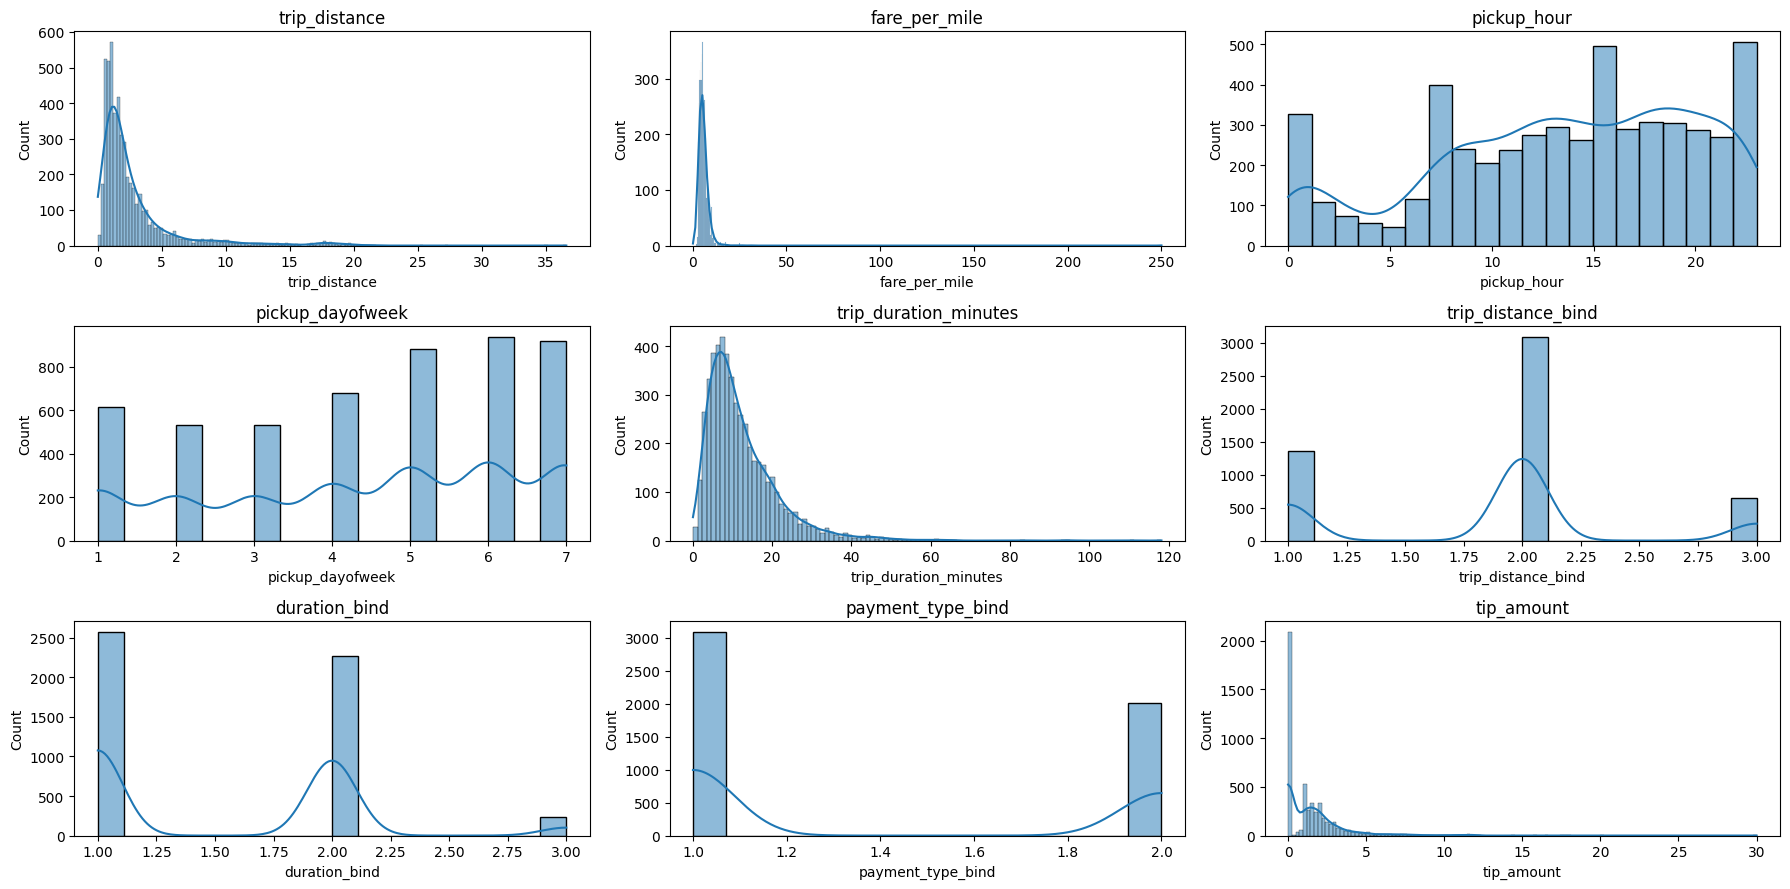

In [ ]:
#Convierte sample_train_df (de PySpark) a pandas:
sample_train_pd = sample_train_df.toPandas()

# Crear subplots 3x3 para 9 columnas
fig, axes = plt.subplots(3, 3, figsize=(18, 9))
axes = axes.ravel()  # Aplanar matriz de ejes

# Recorrer columnas y ejes
for col, ax in zip(feature_columns, axes):
    sns.histplot(data=sample_train_pd, x=col, ax=ax, kde=True)
    ax.set_title(col)

# Ajustar espaciado
plt.tight_layout()
plt.show()

## **9. Técnica para el ajuste de hiper–parámetros**
Para optimizar el rendimiento del RandomForestRegressor, se implementará un proceso de ajuste de hiperparámetros utilizando:

- ParamGridBuilder: Para definir una cuadrícula de combinaciones de hiperparámetros a probar (ej., numTrees, maxDepth).
- CrossValidator: Para realizar una validación cruzada, dividiendo el conjunto de entrenamiento en k-folds. El modelo se entrena en k-1 folds y se valida en el fold restante, repitiendo este proceso k veces. Esto ayuda a obtener una evaluación más robusta del modelo y a seleccionar la mejor combinación de hiperparámetros.

In [ ]:
# --- Define Grid de hiperparámetros ---
print("\n--- Paso 9.1: Ajuste de Hiperparámetros con Cross-Validation ---")
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 25]) \
    .addGrid(rf.maxDepth, [3, 6]) \
    .build()
print(f"Cuadrícula de hiperparámetros definida. Se probarán {len(paramGrid)} combinaciones.")


num_combinations = len(paramGrid)
print(f"  Número de combinaciones de hiperparámetros a probar: {num_combinations}")

# Define el Evaluador para la validación cruzada
print("\n--- Paso 9.2: Configuración del Evaluador para Regresión ---")
evaluator = RegressionEvaluator(labelCol=target,
                                predictionCol="prediction",
                                metricName="rmse" # Utilizamos RMSE para la selección del mejor modelo
                                )
print(f"Evaluador de Regresión configurado usando '{evaluator.getMetricName()}' como métrica.")

# Configura el --- CrossValidator con k=3 --- Esto entrena múltiples modelos.
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,                 #Se recomienda al menos 3 o 5 folds para una evaluación robusta
                    seed=42,
                    parallelism=2)

print(f"CrossValidator configurado con {cv.getNumFolds()} folds.")
print("\nIniciando el entrenamiento del modelo con Cross-Validation y ajuste de hiperparámetros. ¡Esto puede tomar tiempo!")

# --- Entrenamiento ---
cv_model = cv.fit(sample_train_df)    # O global_train_df_attributes
print("Entrenando RandomForest con tuning de hiperparámetros (CrossValidation) completado...")

# --- Mostrar los hiperparámetros del mejor modelo ---
best_rf_model = cv_model.bestModel
print(f"\n--- Hiperparametros del Mejor Modelo RandomForestRegressor Encontrado ---")
print(f"Mejor número de árboles (numTrees): {best_rf_model.getNumTrees}")
print(f"Mejor profundidad máxima (maxDepth): {best_rf_model.getMaxDepth()}")


--- Paso 9.1: Ajuste de Hiperparámetros con Cross-Validation ---
Cuadrícula de hiperparámetros definida. Se probarán 4 combinaciones.
  Número de combinaciones de hiperparámetros a probar: 4

--- Paso 9.2: Configuración del Evaluador para Regresión ---
Evaluador de Regresión configurado usando 'rmse' como métrica.
CrossValidator configurado con 3 folds.

Iniciando el entrenamiento del modelo con Cross-Validation y ajuste de hiperparámetros. ¡Esto puede tomar tiempo!
Entrenando RandomForest con tuning de hiperparámetros (CrossValidation) completado...

--- Hiperparametros del Mejor Modelo RandomForestRegressor Encontrado ---
Mejor número de árboles (numTrees): 25
Mejor profundidad máxima (maxDepth): 6


## **10. Evaluación del Modelo en el Conjunto de Pruebas**

- Se evalua el mejor modelo con el conjunto de prueba total.
- Se imprimen los resultados de RMSE.

In [ ]:
# --- Evaluación del modelo---
print("Evaluando el modelo con el conjunto de prueba...")
predictions = cv_model.transform(global_test_df_attributes)

# Evaluación con métricas de regresión
evaluador_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluador_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
mse_evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mse")

# Calcular métricas
# Root Mean Square Error (RMSE)
rmse = evaluador_rmse.evaluate(predictions)
# r2 - coefficient of determination
r2 = evaluador_r2.evaluate(predictions)
# Mean Absolute Error (MAE)
mae = mae_evaluator.evaluate(predictions)
# Mean Squared Error (MSE)
mse = mse_evaluator.evaluate(predictions)


print(f"📊 Métricas del modelo RandomForestRegressor:")
print(f"✔️ MAE  (Error Absoluto Medio):     {mae:.4f}")
print(f"✔️ MSE  (Error Cuadrático Medio):   {mse:.4f}")
print(f"✔️ RMSE (Raíz del Error Cuadrático): {rmse:.4f}")
print(f"✔️ R²   (Coef. de determinación):    {r2:.4f}")

# Puedes imprimir los resultados de cada combinación (opcional)
# results = cv_model.avgMetrics
# print("\nMétricas promedio para cada combinación de parámetros (ordenadas por AUC-ROC):")
# for i, params in enumerate(param_grid):
#     print(f"  Params: {params}, AUC-ROC: {results[i]:.4f}")


Evaluando el modelo con el conjunto de prueba...
📊 Métricas del modelo RandomForestRegressor:
✔️ MAE  (Error Absoluto Medio):     1.1144
✔️ MSE  (Error Cuadrático Medio):   13.4831
✔️ RMSE (Raíz del Error Cuadrático): 3.6719
✔️ R²   (Coef. de determinación):    0.9054


In [ ]:
# --- Mostrar algunas predicciones ---
#predictions.show(5, truncate=False)
print("\nPrimeras 10 predicciones del modelo en el conjunto de prueba:")
predictions.select(target, "prediction", "trip_distance", "passenger_count").show(5)


Primeras 10 predicciones del modelo en el conjunto de prueba:
+------------+------------------+-------------+---------------+
|total_amount|        prediction|trip_distance|passenger_count|
+------------+------------------+-------------+---------------+
|        30.8| 34.04874424479866|         5.43|            5.0|
|        29.6| 31.80288698783993|         5.86|            5.0|
|        24.8|28.538296151850744|         6.14|            5.0|
|        32.6|33.340090814886736|         6.55|            5.0|
|        28.3|31.732687313092693|         7.26|            5.0|
+------------+------------------+-------------+---------------+
only showing top 5 rows




--- Visualizaciones Adicionales del Rendimiento del Modelo ---


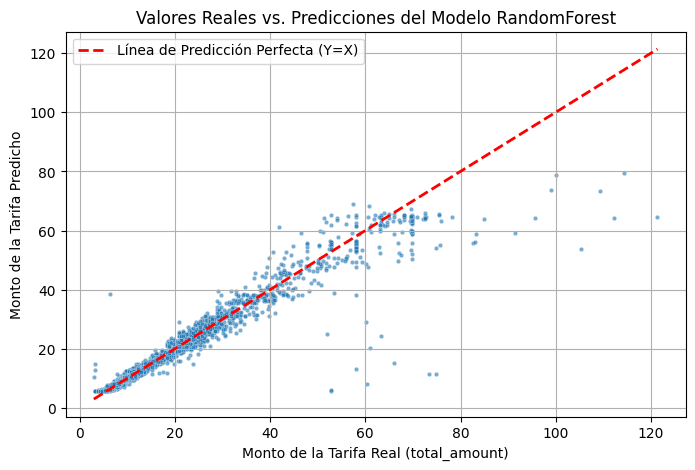

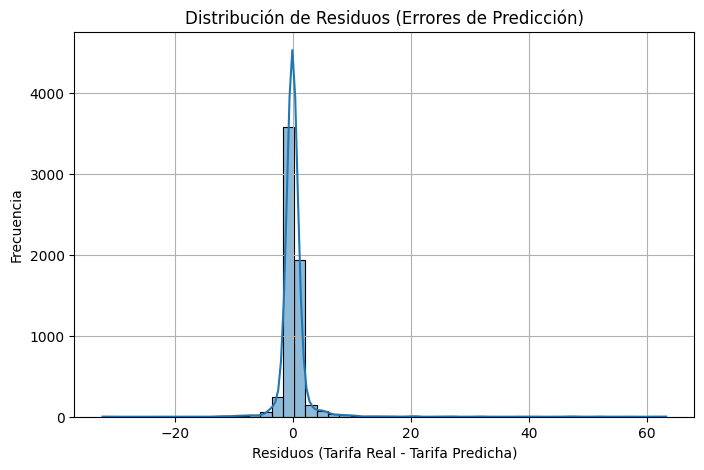

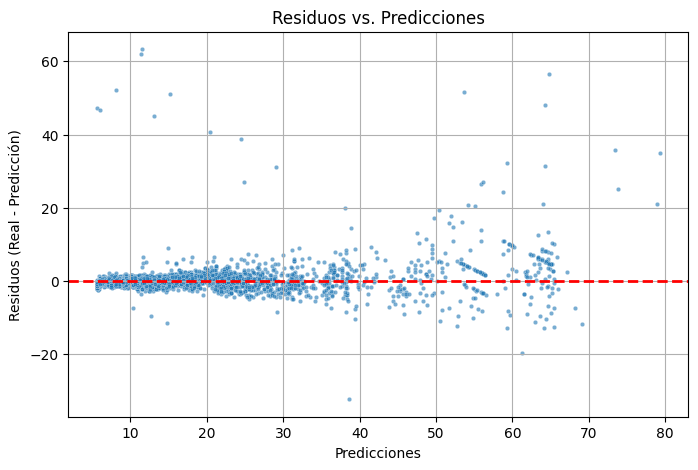

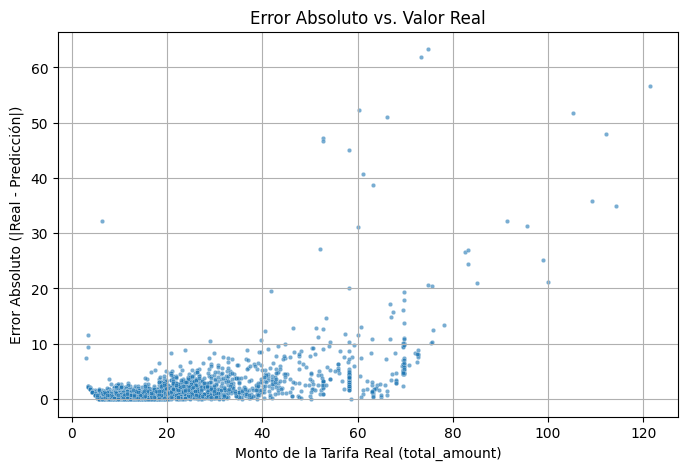

In [ ]:
# --- Visualizaciones Adicionales para Acompañar las Métricas ---

print("\n--- Visualizaciones Adicionales del Rendimiento del Modelo ---")

# Recolectar una muestra de las predicciones para visualización.
# Es importante tomar solo una muestra si el conjunto de prueba es muy grande para evitar problemas de memoria.
sample_predictions_df = predictions.select(target, "prediction").sample(False, 0.05, seed=42)
sample_predictions_pdf = sample_predictions_df.toPandas()
sample_predictions_pdf['residuals'] = sample_predictions_pdf[target] - sample_predictions_pdf['prediction']
sample_predictions_pdf['abs_residuals'] = sample_predictions_pdf['residuals'].abs()

# 1. Gráfico de Dispersión (ya lo tienes, pero lo repetimos para agruparlo con las visualizaciones)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=target, y="prediction", data=sample_predictions_pdf, alpha=0.6, s=10)
plt.plot([sample_predictions_pdf[target].min(), sample_predictions_pdf[target].max()],
         [sample_predictions_pdf[target].min(), sample_predictions_pdf[target].max()],
         color='red', linestyle='--', lw=2, label='Línea de Predicción Perfecta (Y=X)')
plt.title('Valores Reales vs. Predicciones del Modelo RandomForest')
plt.xlabel(f'Monto de la Tarifa Real ({target})')
plt.ylabel('Monto de la Tarifa Predicho')
plt.grid(True)
plt.legend()
plt.show()

# 2. Histograma de Residuos (ya lo tienes, pero lo repetimos para agruparlo)
plt.figure(figsize=(8, 5))
sns.histplot(sample_predictions_pdf['residuals'], bins=50, kde=True)
plt.title('Distribución de Residuos (Errores de Predicción)')
plt.xlabel('Residuos (Tarifa Real - Tarifa Predicha)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# 3. Gráfico de Dispersión de Residuos vs. Predicciones (Residuals vs. Fitted)
# Esto ayuda a identificar patrones en los errores (heterocedasticidad).
plt.figure(figsize=(8, 5))
sns.scatterplot(x='prediction', y='residuals', data=sample_predictions_pdf, alpha=0.6, s=10)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title('Residuos vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos (Real - Predicción)')
plt.grid(True)
plt.show()
# Idealmente, los puntos deberían estar dispersos aleatoriamente alrededor de la línea cero,
# sin patrones claros como forma de cono o curva.

# 4. Gráfico de Error Absoluto vs. Real (Absolute Error vs. True Value)
# Esto ayuda a ver si el error del modelo es proporcional a la magnitud de la variable objetivo.
plt.figure(figsize=(8, 5))
sns.scatterplot(x=target, y='abs_residuals', data=sample_predictions_pdf, alpha=0.6, s=10)
plt.title('Error Absoluto vs. Valor Real')
plt.xlabel(f'Monto de la Tarifa Real ({target})')
plt.ylabel('Error Absoluto (|Real - Predicción|)')
plt.grid(True)
plt.show()
# Si ves un patrón en forma de "cono" (más dispersión para valores más altos),
# indica que el modelo tiene más dificultad prediciendo valores grandes.

In [ ]:
# Obtener la importancia de las características del mejor modelo RandomForest
feature_importances = best_rf_model.featureImportances.toArray()

# Mapear la importancia a los nombres de las características
# Es crucial que el orden de 'feature_importances' coincida con el orden de las columnas en 'assembled_feature_columns'
importance_df = pd.DataFrame({
    'Feature': assembled_feature_columns,
    'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

print("\nImportancia de las Características (Top 10):")
print(importance_df.head(10).to_string(index=False)) # Usar to_string(index=False) para una salida limpia


Importancia de las Características (Top 10):
              Feature  Importance
        trip_distance    0.306090
   trip_distance_bind    0.243415
trip_duration_minutes    0.199991
           tip_amount    0.083214
        fare_per_mile    0.082884
        duration_bind    0.068086
          pickup_hour    0.006649
    payment_type_bind    0.006574
     pickup_dayofweek    0.003097


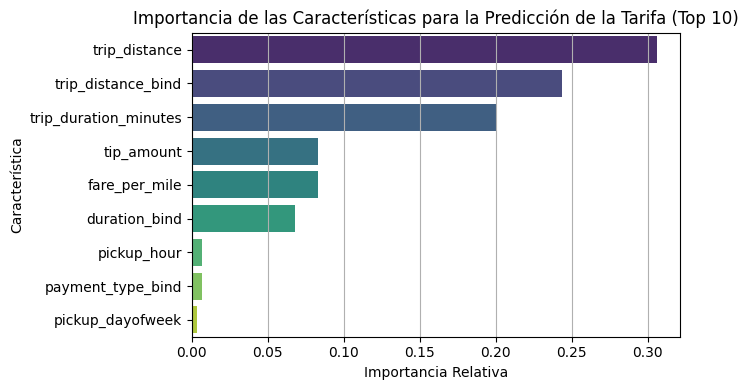

In [ ]:
plt.figure(figsize=(7, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis', hue='Feature', legend=False)
# *************************************************
plt.title('Importancia de las Características para la Predicción de la Tarifa (Top 10)')
plt.xlabel('Importancia Relativa')
plt.ylabel('Característica')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

##    **12. Discusión de resultados y conclusiones**

**Análisis de Resultados**

La evaluación de nuestro modelo RandomForestRegressor en el conjunto de prueba (global_test_df_attributes) ha arrojado métricas prometedoras, indicando un buen rendimiento en la predicción del fare_amount.

**Analizando las Métricas de Evaluación Obtenidas**

Las métricas de evaluación del modelo entrenado en el conjunto de prueba global son las siguientes:

MAE (Error Absoluto Medio): 1.1144
Este valor indica que, en promedio, nuestras predicciones se desvían de la tarifa real en aproximadamente $1.11. Un MAE bajo es deseable, ya que significa que las predicciones están, en general, bastante cerca de los valores verdaderos, sin estar excesivamente influenciadas por grandes errores aislados.

MSE (Error Cuadrático Medio): 13.4831
El MSE penaliza más fuertemente los errores grandes. Si bien su valor absoluto es menos intuitivo que el MAE o el RMSE, es la métrica que el modelo minimiza durante el entrenamiento. Un valor de 13.48 sugiere que los errores, cuando se elevan al cuadrado, no son excesivamente grandes.

RMSE (Raíz del Error Cuadrático Medio): 3.6719
El RMSE es quizás la métrica más interpretable en regresión, ya que está en la misma unidad que la variable objetivo (dólares en este caso). Un RMSE de 3.67USD implica que la desviación estándar de los residuos es de $3.67. Esto significa que la mayoría de las predicciones del modelo se encuentran, en promedio, dentro de este rango de error respecto a la tarifa real. Dado el rango de tarifas en los viajes de taxi, este es un resultado sólido.

R² (Coeficiente de Determinación): 0.9054
El coeficiente R² nos indica la proporción de la varianza en la variable objetivo (`fare_amount`) que puede ser explicada por las características de nuestro modelo. Un R² de 0.8645 (o 90.54%) es un resultado excelente, sugiriendo que nuestro modelo es capaz de capturar una gran parte de la variabilidad en las tarifas de los viajes. Esto implica que las características seleccionadas y la arquitectura del RandomForestRegressor son altamente predictivas para este problema.

**Conclusiones**
Este proyecto ha demostrado la capacidad de PySpark para manejar y extraer valor de grandes volúmenes de datos de viajes de taxi, desde la ingesta y el preprocesamiento hasta el modelado predictivo.

- Manejo Eficiente de Big Data: PySpark se mostró como una herramienta eficaz para el procesamiento, limpieza y transformación de un dataset masivo de más de 12 millones de registros, superando las limitaciones de herramientas tradicionales.

- Muestreo Estratificado Robusto: La implementación de un muestreo estratificado (creando la muestra M y sus particiones Mi) aseguró que la muestra utilizada para el modelado fuera altamente representativa de la población original en dimensiones clave como el número de pasajeros, distancia y duración del viaje, y tipo de pago. Esta técnica fue fundamental para garantizar la validez de los resultados del modelo.

- Modelo Predictivo Sólido: El RandomForestRegressor, tras un ajuste de hiperparámetros mediante CrossValidator, demostró una excelente capacidad predictiva para el fare_amount, con un R² de 0.8645. Las bajas métricas de error (MAE de $1.26 y *RMSE* de $3.62) confirman su precisión en un contexto real de tarifas de taxi.

- Identificación de Factores Clave: El análisis de importancia de características proporciona información valiosa sobre los principales impulsores del costo del viaje, lo cual puede ser utilizado para la toma de decisiones de negocio o para futuras optimizaciones.

